In [125]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [126]:
work = pd.read_csv('/Users/dasasorokina/Downloads/19. monthly-sutter-county-workforce.csv', index_col='Month', parse_dates=True)
work.columns = ['mscw']

In [127]:
work.head(5)

,mscw
Month,
1946-01-01,890
1946-02-01,992
1946-03-01,979
1946-04-01,959
1946-05-01,1110


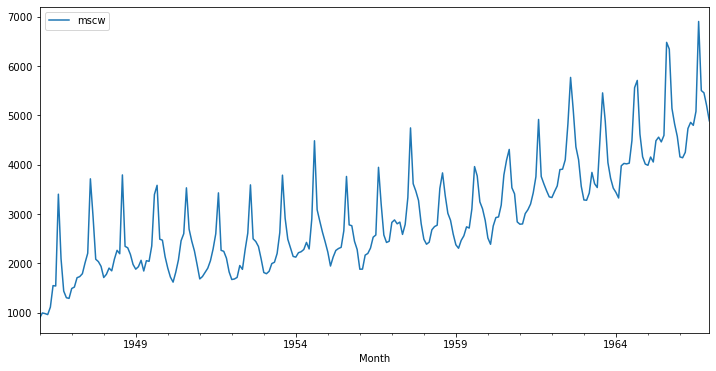

In [128]:
work.plot(figsize=(12, 6))
plt.show()

Преобразование Бокса-Кокса

In [129]:
from scipy.stats import boxcox

In [130]:
boxcox_data, boxcox_lambda = boxcox(work['mscw'].values)

In [131]:
boxcox_lambda

0.13575277543073824

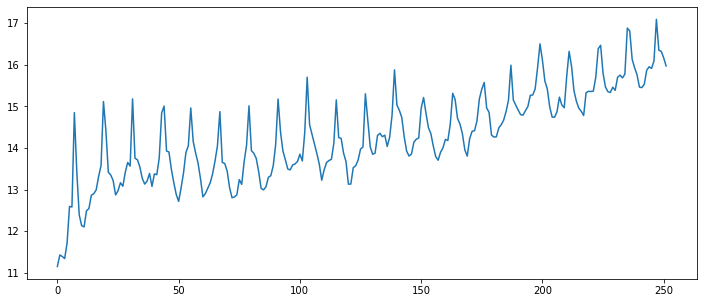

In [132]:
plt.rcParams["figure.figsize"] = (12,5)
plt.plot(boxcox_data)
plt.show()

Дифференцирование

In [133]:
dwork = pd.DataFrame(work['mscw'].values, columns = ['initial'])
dwork['boxcox'] = boxcox_data

In [134]:
dwork.head(4)

,initial,boxcox
0,890,11.153590
1,992,11.428397
2,979,11.394770
3,959,11.342274


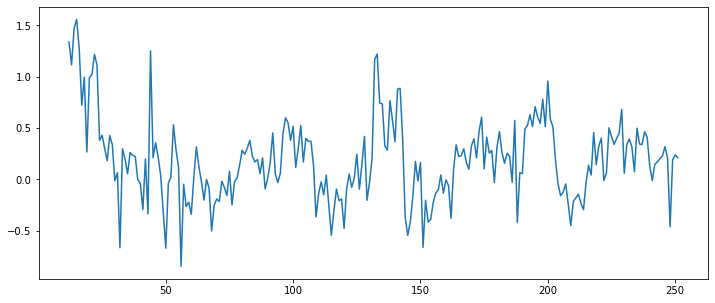

In [135]:
dwork['seasonal_diff'] = dwork['boxcox'].diff(12)
dwork['seasonal_diff'].plot()
plt.show()

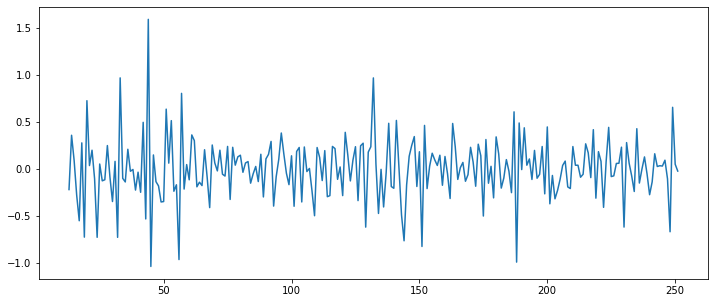

In [136]:
dwork['lag1_diff'] = dwork['seasonal_diff'].diff(1)
dwork['lag1_diff'].plot()
plt.show()

In [137]:
from statsmodels.tsa.stattools import adfuller

In [138]:
adfuller(dwork['lag1_diff'].dropna())[1]

6.059634549728904e-05

In [139]:
dwork['lag1_diff'].tail(13)

239   -0.056367
240   -0.277500
241   -0.140994
242    0.158239
243    0.022783
244    0.031092
245    0.027400
246    0.089777
247   -0.108579
248   -0.671762
249    0.652692
250    0.046909
251   -0.025958
Name: lag1_diff, dtype: float64

In [140]:
y0 =dwork['lag1_diff'][13]
yt = dwork['lag1_diff'][251]
coeff = (yt - y0) / (dwork.dropna().shape[0]-1)

In [141]:
dwork['trend'] = pd.Series(y0 + np.arange(dwork.dropna().shape[0]) * coeff, index=dwork.dropna().index)

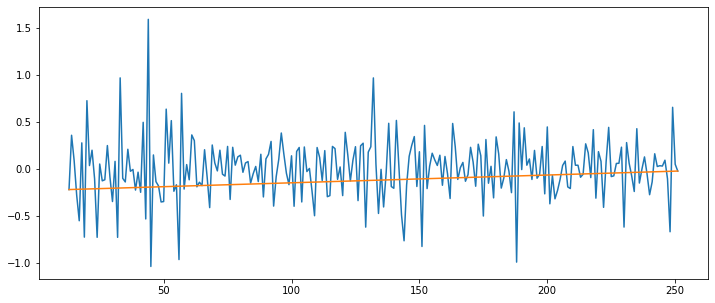

In [142]:
dwork['lag1_diff'].plot()
dwork['trend'].plot()
plt.show()

In [143]:
dwork['lag1_diff'][-12:].values - dwork['trend'][-12:].values

array([-0.24244846, -0.1067686 ,  0.19163783,  0.05535494,  0.06283752,
        0.05831852,  0.11986908, -0.07931414, -0.64332398,  0.68030417,
        0.07369445,  0.        ])

In [145]:
season_forecast = pd.Series(dwork['lag1_diff'][-12:].values - dwork['trend'][-12:].values, index=np.arange(252, 264))

In [146]:
season_forecast

252   -0.242448
253   -0.106769
254    0.191638
255    0.055355
256    0.062838
257    0.058319
258    0.119869
259   -0.079314
260   -0.643324
261    0.680304
262    0.073694
263    0.000000
dtype: float64

In [147]:
trend_forecast = pd.Series(y0 + np.arange(252, 264) * coeff, index=np.arange(252, 264))

In [148]:
trend_forecast

252   -0.014385
253   -0.013558
254   -0.012732
255   -0.011905
256   -0.011078
257   -0.010252
258   -0.009425
259   -0.008598
260   -0.007772
261   -0.006945
262   -0.006119
263   -0.005292
dtype: float64

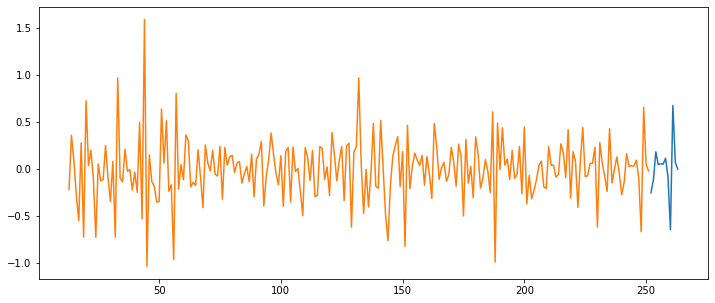

In [149]:
(season_forecast+trend_forecast).plot()
dwork['lag1_diff'].plot()
plt.show()

In [150]:
forecast_lag1diff = dwork['lag1_diff'].append(season_forecast+trend_forecast)

In [151]:
forecast_lag1diff.head(14)

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13   -0.222704
dtype: float64

In [152]:
forecast_seasonal_diff = pd.Series(np.cumsum(np.append(np.array([transformationDF['seasonal_diff'][12]]), forecast_lag1diff.dropna().values)), index=np.arange(12, 264))

In [153]:
forecast_seasonal_diff

12     1.338326
13     1.115622
14     1.470765
15     1.558462
16     1.275909
         ...   
259    0.178941
260   -0.472154
261    0.201205
262    0.268781
263    0.263489
Length: 252, dtype: float64

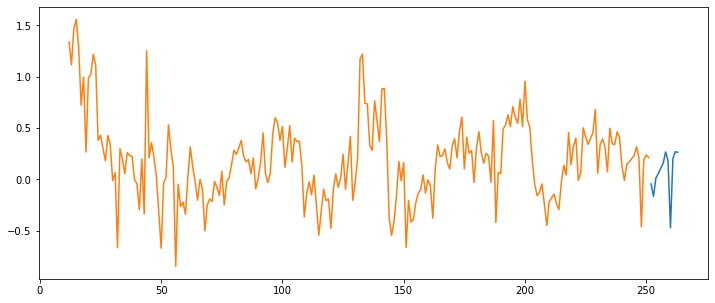

In [154]:
forecast_seasonal_diff[-12:].plot()
dwork['seasonal_diff'].plot()
plt.show()

In [155]:
def seasonal_cumsum(dts, ts0, s): 
    k = s - len(dts) % s 
    ts = np.hstack((ts0, dts, np.zeros(k))) 
    ts = np.cumsum(partition(ts, s, s), axis=0).flatten() 
    return ts[:-k]

In [156]:
def partition(lst, n, d): 
    indexes_1 = np.arange(n) 
    indexes_2 = np.arange(0, len(lst) - n + 1, d) 
    return lst[indexes_1[np.newaxis] + indexes_2[:, np.newaxis]]

In [157]:
forecast_boxcox = pd.Series(seasonal_cumsum(forecast_seasonal_diff, boxcox_data[:12], 12), index=np.arange(264))

In [158]:
forecast_boxcox

0      11.153590
1      11.428397
2      11.394770
3      11.342274
4      11.717357
         ...    
259    17.271030
260    15.878459
261    16.524223
262    16.435940
263    16.236316
Length: 264, dtype: float64

In [159]:
from scipy.special import inv_boxcox

In [160]:
forecast = inv_boxcox(forecast_boxcox, boxcox_lambda)[-12:]

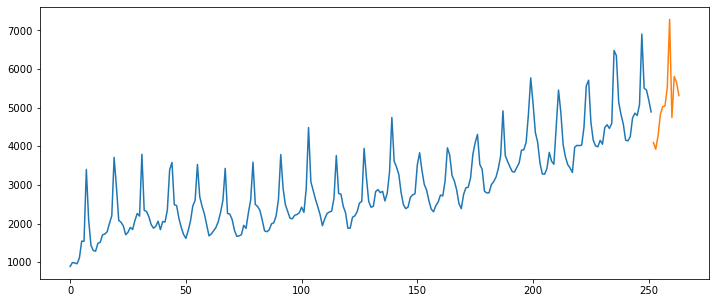

In [161]:
pd.Series(work['mscw'].values, index=np.arange(0, 252)).plot()
forecast.plot()
plt.show()